In [1]:
import traceback

In [2]:
import os
import tensorflow as tf
import numpy as np
import trimesh
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
from sklearn.model_selection import train_test_split
import shutil
import json
import warnings
warnings.filterwarnings('ignore')

In [3]:
# =============================================================================
# Î©îÏâ¨ ÌååÏùºÏùÑ Î∂àÎü¨Ïò§Îäî Ïó≠Ìï†
# =============================================================================

class MeshLoader:
    def __init__(self, data_dir: str, supported_formats=None):
        self.data_dir = Path(data_dir)
        self.supported_formats = supported_formats or ['.npy', '.obj', '.ply', '.stl', '.off']
        self.mesh_files = self._collect_mesh_files()

    def _collect_mesh_files(self) -> List[Path]:
        files = []
        for ext in self.supported_formats:
            files.extend(self.data_dir.glob(f"*{ext}"))
        return sorted(files)

    def get_all_file_paths(self) -> List[str]:
        return [str(f) for f in self.mesh_files]

    def load_mesh_data(self, file_path: str) -> Dict:
        try:
            if file_path.endswith('.npy'):
                data = np.load(file_path, allow_pickle=True)
                if isinstance(data, np.lib.npyio.NpzFile):  # .npz ÌôïÏû•ÏûêÎ•º ÎåÄÎπÑ
                    data = dict(data)
                elif hasattr(data, 'item'):
                    data = data.item()
                return {
                    'vertices': np.array(data['vertices'], dtype=np.float32),
                    'faces': np.array(data['faces'], dtype=np.int32),
                    'file_path': file_path
                }

            # Í∑∏ Ïô∏ Ìè¨Îß∑ÏùÄ trimeshÎ°ú Ï≤òÎ¶¨
            mesh = trimesh.load(file_path, force='mesh')
            if hasattr(mesh, 'geometry'):
                mesh = list(mesh.geometry.values())[0]
            vertices = np.array(mesh.vertices, dtype=np.float32)
            faces = np.array(mesh.faces, dtype=np.int32)
            if len(vertices) == 0 or len(faces) == 0:
                raise ValueError("Îπà Î©îÏâ¨")
            return {'vertices': vertices, 'faces': faces, 'file_path': file_path}

        except Exception as e:
            print(f"‚ö†Ô∏è Î°úÎî© Ïã§Ìå® {file_path}: {e}")
            return self._create_dummy_mesh()

    def _create_dummy_mesh(self) -> Dict:
        vertices = np.array([
            [0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.5, 0.866, 0.0],
            [0.5, 0.289, 0.816]
        ], dtype=np.float32)
        faces = np.array([
            [0, 1, 2],
            [0, 2, 3],
            [0, 3, 1],
            [1, 3, 2]
        ], dtype=np.int32)
        return {'vertices': vertices, 'faces': faces, 'file_path': 'dummy'}

In [4]:
class MeshPreprocessor:
    def __init__(self, max_vertices: int, max_faces: int):
        self.max_vertices = max_vertices
        self.max_faces = max_faces

    def preprocess(self, mesh_data: Dict) -> Dict:
        vertices = self._normalize_vertices(mesh_data['vertices'])
        vertices, faces = self._resize_mesh(vertices, mesh_data['faces'])
        normals = self._compute_face_normals(vertices, faces)
        features = self._compute_edge_features(vertices, faces)
        
        print("ÏÉòÌîå features:")
        print(features[:5])
        print("Î©¥ Í∞úÏàò:", len(faces))
        print("Ï†ïÏ†ê ÌèâÍ∑† Í±∞Î¶¨:", np.mean(np.linalg.norm(vertices, axis=1)))

        return {
            'vertices': tf.constant(vertices, dtype=tf.float32),
            'faces': tf.constant(faces, dtype=tf.int32),
            'normals': tf.constant(normals, dtype=tf.float32),
            'features': tf.constant(features, dtype=tf.float32)
        }

    def _normalize_vertices(self, vertices: np.ndarray) -> np.ndarray:
        center = vertices.mean(axis=0)
        vertices -= center
        max_dist = np.max(np.linalg.norm(vertices, axis=1))
        if max_dist > 0:
            vertices /= max_dist
        print("ÏõêÎ≥∏ vertex ÏòàÏãú:", vertices[:3])
        print("normalize ÌõÑ:", vertices[:3])
        return vertices

    def _resize_mesh(self, vertices: np.ndarray, faces: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_vertices = len(vertices)
        n_faces = len(faces)
        if n_vertices > self.max_vertices:
            indices = np.linspace(0, n_vertices-1, self.max_vertices, dtype=int)
            vertices = vertices[indices]
            faces = self._remap_faces(faces, indices)
        elif n_vertices < self.max_vertices:
            padding = np.tile(vertices[-1:], (self.max_vertices - n_vertices, 1)) if n_vertices else np.zeros((self.max_vertices, 3), np.float32)
            vertices = np.vstack([vertices, padding])
        if len(faces) > self.max_faces:
            indices = np.linspace(0, len(faces)-1, self.max_faces, dtype=int)
            faces = faces[indices]
        elif len(faces) < self.max_faces:
            padding = np.tile(faces[-1:], (self.max_faces - len(faces), 1)) if len(faces) else np.zeros((self.max_faces, 3), dtype=np.int32)
            faces = np.vstack([faces, padding])
        return vertices, faces

    def _remap_faces(self, faces: np.ndarray, vertex_indices: np.ndarray) -> np.ndarray:
        old_to_new = {old: new for new, old in enumerate(vertex_indices)}
        valid_faces = [[old_to_new[v] for v in face] for face in faces if all(v in old_to_new for v in face)]
        return np.array(valid_faces, dtype=np.int32) if valid_faces else np.zeros((0, 3), dtype=np.int32)

    def _compute_face_normals(self, vertices: np.ndarray, faces: np.ndarray) -> np.ndarray:
        normals = []
        for face in faces:
            if len(np.unique(face)) == 3:
                v0, v1, v2 = vertices[face]
                normal = np.cross(v1 - v0, v2 - v0)
                norm = np.linalg.norm(normal)
                normals.append(normal / norm if norm > 1e-8 else [0.0, 0.0, 1.0])
            else:
                normals.append([0.0, 0.0, 1.0])
        while len(normals) < self.max_faces:
            normals.append([0.0, 0.0, 1.0])
        return np.array(normals[:self.max_faces], dtype=np.float32)

    def _compute_edge_features(self, vertices: np.ndarray, faces: np.ndarray) -> np.ndarray:
        features = []
        for face in faces:
            if len(np.unique(face)) != 3:
                # ÎπÑÏ†ïÏÉÅ face: Ï§ëÎ≥µÎêú vertex
                features.append([0.0, 0.0, 1.0, 0.0, 0.0])
                continue

            v0, v1, v2 = vertices[face]

            # Edges
            e0 = v1 - v0
            e1 = v2 - v1
            e2 = v0 - v2

            # Edge lengths
            len0 = np.linalg.norm(e0)
            len1 = np.linalg.norm(e1)
            len2 = np.linalg.norm(e2)

            # Area (Heron's formula for better numerical stability)
            s = 0.5 * (len0 + len1 + len2)
            area = max(np.sqrt(max(s * (s - len0) * (s - len1) * (s - len2), 0)), 1e-12)

            # Perimeter
            perimeter = len0 + len1 + len2

            # Aspect Ratio (based on triangle quality metric)
            aspect_ratio = max(len0, len1, len2) / (min(len0, len1, len2) + 1e-8)

            # Angle between two edges (robustly)
            cos_angle = np.dot(e0, -e2) / ((len0 * len2) + 1e-8)
            angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))

            # Centroid distance from origin
            centroid = (v0 + v1 + v2) / 3.0
            centroid_distance = np.linalg.norm(centroid)

            features.append([area, perimeter, aspect_ratio, angle, centroid_distance])

        # Padding
        while len(features) < self.max_faces:
            features.append([0.0, 0.0, 1.0, 0.0, 0.0])

        return np.array(features[:self.max_faces], dtype=np.float32)


In [5]:
class MeshDataManager:
    def __init__(self, source_dir: str, training_dir: str, max_vertices: int = 5000, max_faces: int = 10000):
        self.source_dir = Path(source_dir)
        self.training_dir = Path(training_dir)
        self.max_vertices = max_vertices
        self.max_faces = max_faces

        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨ Íµ¨Ï°∞ ÏÉùÏÑ±
        self.train_dir = self.training_dir / "train"
        self.val_dir = self.training_dir / "val"
        self.test_dir = self.training_dir / "test"
        self.processed_dir = self.training_dir / "processed"
        self.cache_dir = self.training_dir / "cache"
        self.analysis_dir = self.training_dir / "analysis"

        for dir_path in [
            self.training_dir, self.train_dir, self.val_dir,
            self.test_dir, self.processed_dir, self.cache_dir, self.analysis_dir
        ]:
            dir_path.mkdir(parents=True, exist_ok=True)

        # Ï∂îÌõÑ ÏÇ¨Ïö©ÏùÑ ÏúÑÌïú ÌååÏùº Î¶¨Ïä§Ìä∏ Ï†ÄÏû•Ïö© Î≥ÄÏàò Ï¥àÍ∏∞Ìôî
        self.train_files: List[str] = []
        self.val_files: List[str] = []
        self.test_files: List[str] = []

    def prepare_training_data(self, train_ratio: float = 0.7, val_ratio: float = 0.2, test_ratio: float = 0.1):
        """ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º ÌïôÏäµ/Í≤ÄÏ¶ù/ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏Î°ú Î∂ÑÌï†ÌïòÏó¨ Î≥µÏÇ¨"""
        print("üìÅ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ï§ë...")

        loader = MeshLoader(self.source_dir)
        all_files = loader.get_all_file_paths()

        if len(all_files) == 0:
            print("‚ùå ÏõêÎ≥∏ ÎîîÎ†âÌÜ†Î¶¨ÏóêÏÑú Î©îÏâ¨ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
            return False

        print(f"Ï¥ù {len(all_files)}Í∞úÏùò Î©îÏâ¨ ÌååÏùº Î∞úÍ≤¨")

        # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
        train_files, temp_files = train_test_split(all_files, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        # Î©§Î≤Ñ Î≥ÄÏàòÎ°ú Ï†ÄÏû•
        self.train_files = train_files
        self.val_files = val_files
        self.test_files = test_files

        # ÌååÏùº Î≥µÏÇ¨
        datasets = [
            (train_files, self.train_dir, "train"),
            (val_files, self.val_dir, "validation"),
            (test_files, self.test_dir, "test")
        ]

        for files, target_dir, name in datasets:
            print(f"{name} ÏÑ∏Ìä∏: {len(files)}Í∞ú ÌååÏùº Î≥µÏÇ¨ Ï§ë...")
            for file_path in files:
                source_file = Path(file_path)
                target_file = target_dir / source_file.name
                if not target_file.exists():
                    shutil.copy2(source_file, target_file)

        # Î∂ÑÌï† Ï†ïÎ≥¥ Ï†ÄÏû•
        split_info = {
            'total_files': len(all_files),
            'train_files': len(train_files),
            'val_files': len(val_files),
            'test_files': len(test_files),
            'train_ratio': train_ratio,
            'val_ratio': val_ratio,
            'test_ratio': test_ratio
        }

        with open(self.training_dir / "split_info.json", 'w') as f:
            json.dump(split_info, f, indent=2)

        print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ÏôÑÎ£å!")
        print(f"  - ÌïôÏäµ: {len(train_files)}Í∞ú")
        print(f"  - Í≤ÄÏ¶ù: {len(val_files)}Í∞ú")
        print(f"  - ÌÖåÏä§Ìä∏: {len(test_files)}Í∞ú")

        return True

In [6]:
class MeshDatasetTF:
    def __init__(self, data_dir: str, cache_dir: Optional[str] = None,
                 max_vertices: int = 5000, max_faces: int = 10000):
        self.source_dir = data_dir
        self.loader = MeshLoader(data_dir)
        self.preprocessor = MeshPreprocessor(max_vertices, max_faces)
        self.max_vertices = max_vertices
        self.max_faces = max_faces
        self.cache_dir = Path(cache_dir or (Path(data_dir) / "cache"))
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        self.mesh_files = self.loader.get_all_file_paths()

    def _load_and_process(self, file_path_tensor):
        file_path = file_path_tensor.numpy().decode('utf-8')
        cache_file = self.cache_dir / f"{Path(file_path).stem}_{hash(file_path) % 10000}.pkl"

        if cache_file.exists():
            with open(cache_file, 'rb') as f:
                mesh_data = pickle.load(f)
        else:
            raw = self.loader.load_mesh_data(file_path)
            mesh_data = self.preprocessor.preprocess(raw)
            mesh_data_np = {k: v.numpy() for k, v in mesh_data.items()}
            with open(cache_file, 'wb') as f:
                pickle.dump(mesh_data_np, f)

        return tuple(tf.constant(mesh_data[k], dtype=tf.float32 if k != 'faces' else tf.int32)
                     for k in ['vertices', 'faces', 'normals', 'features'])

    def create_dataset(self, batch_size=8, shuffle=True, prefetch_buffer=tf.data.AUTOTUNE):
        # ÌååÏùºÏù¥ ÏóÜÎäî Í≤ΩÏö∞ Îπà Îç∞Ïù¥ÌÑ∞ÏÖã Î∞òÌôò
        if len(self.mesh_files) == 0:
            print(f"‚ö†Ô∏è Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨Ïóê Î©îÏâ¨ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§: {self.loader.data_dir}")
            # Îπà Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
            dummy_data = {
                'vertices': tf.zeros([batch_size, self.max_vertices, 3], dtype=tf.float32),
                'faces': tf.zeros([batch_size, self.max_faces, 3], dtype=tf.int32),
                'normals': tf.zeros([batch_size, self.max_faces, 3], dtype=tf.float32),
                'features': tf.zeros([batch_size, self.max_faces, 5], dtype=tf.float32)
            }
            return tf.data.Dataset.from_tensor_slices(dummy_data).take(0)
        
        ds = tf.data.Dataset.from_tensor_slices(self.mesh_files)
        
        # shuffleÏùÄ ÌååÏùºÏù¥ 1Í∞ú Ïù¥ÏÉÅÏùº ÎïåÎßå Ï†ÅÏö©
        if shuffle and len(self.mesh_files) > 1:
            ds = ds.shuffle(len(self.mesh_files))
        elif shuffle and len(self.mesh_files) == 1:
            print("‚ö†Ô∏è ÌååÏùºÏù¥ 1Í∞úÎøêÏù¥ÎØÄÎ°ú shuffleÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
            
        ds = ds.map(lambda path: tf.py_function(
            self._load_and_process, inp=[path],
            Tout=[tf.float32, tf.int32, tf.float32, tf.float32]
        ))
        ds = ds.map(lambda v, f, n, feat: {
            'vertices': tf.reshape(v, [self.max_vertices, 3]),
            'faces': tf.reshape(f, [self.max_faces, 3]),
            'normals': tf.reshape(n, [self.max_faces, 3]),
            'features': tf.reshape(feat, [self.max_faces, 5])
        })
        return ds.batch(batch_size).prefetch(prefetch_buffer)

def setup_environment(source_dir: str, training_dir: str, 
                             max_vertices: int = 2048, max_faces: int = 4096):
    """ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï Î∞è Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ"""
    print("üöÄ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏãúÏûë")
    
    # 1. Îç∞Ïù¥ÌÑ∞ Îß§ÎãàÏ†Ä ÏÉùÏÑ±
    data_manager = MeshDataManager(
        source_dir=source_dir,
        training_dir=training_dir,
        max_vertices=max_vertices,
        max_faces=max_faces
    )
    
    # 2. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    if not data_manager.prepare_training_data():
        return None
    
    # 3. ÏöîÏïΩ Ï†ïÎ≥¥ Ï†ÄÏû•
    summary = {
        'setup_completed': True,
        'source_dir': source_dir,
        'training_dir': training_dir,
        'max_vertices': max_vertices,
        'max_faces': max_faces
    }
    
    with open(data_manager.training_dir / "setup_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("‚úÖ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏôÑÎ£å!")
    print(f"üìÅ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨: {training_dir}")
    
    return data_manager

def create_datasets(training_dir: str, batch_size: int = 8, 
                           max_vertices: int = 5000, max_faces: int = 10000):
    """ÌïôÏäµÏö© TensorFlow Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±"""
    print("üîÑ TensorFlow Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Ï§ë...")
    
    training_path = Path(training_dir)
    cache_dir = training_path / "cache"
    
    # Í∞Å ÎîîÎ†âÌÜ†Î¶¨Ïùò ÌååÏùº Í∞úÏàò ÌôïÏù∏
    train_files = list((training_path / "train").glob("*.*"))
    val_files = list((training_path / "val").glob("*.*"))
    test_files = list((training_path / "test").glob("*.*"))
    
    print(f"üìä Îç∞Ïù¥ÌÑ∞ ÌòÑÌô©:")
    print(f"  - ÌïôÏäµ: {len(train_files)}Í∞ú ÌååÏùº")
    print(f"  - Í≤ÄÏ¶ù: {len(val_files)}Í∞ú ÌååÏùº")
    print(f"  - ÌÖåÏä§Ìä∏: {len(test_files)}Í∞ú ÌååÏùº")
    
    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_dataset = MeshDatasetTF(
        data_dir=str(training_path / "train"),
        cache_dir=str(cache_dir / "train"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=True)
    
    val_dataset = MeshDatasetTF(
        data_dir=str(training_path / "val"),
        cache_dir=str(cache_dir / "val"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)
    
    test_dataset = MeshDatasetTF(
        data_dir=str(training_path / "test"),
        cache_dir=str(cache_dir / "test"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)
    
    print("‚úÖ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± ÏôÑÎ£å!")
    print(f"  - Î∞∞Ïπò ÌÅ¨Í∏∞: {batch_size}")
    print(f"  - ÏµúÎåÄ Ï†ïÏ†ê Ïàò: {max_vertices}")
    print(f"  - ÏµúÎåÄ Î©¥ Ïàò: {max_faces}")
    
    return train_dataset, val_dataset, test_dataset

ÌäπÏÑ± Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî ÌÅ¥ÎûòÏä§

In [7]:
# =============================================================================
# ÌäπÏÑ± Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî ÌÅ¥ÎûòÏä§
# =============================================================================

class MeshFeatureAnalyzer:
    def __init__(self, dataset: MeshDatasetTF):
        self.dataset = dataset
        self.feature_columns = ['area', 'perimeter', 'aspect_ratio', 'angle', 'centroid_distance']
        
    def analyze_features(self, dirs: List[str], num_samples: Union[int, None] = None) -> pd.DataFrame:
        """Î©îÏâ¨ ÌååÏùºÎì§Ïùò ÌäπÏÑ±ÏùÑ Î∂ÑÏÑùÌïòÏó¨ DataFrameÏúºÎ°ú Î∞òÌôò"""
        print(f"üìä {num_samples}Í∞ú ÏÉòÌîåÏùò ÌäπÏÑ±ÏùÑ Î∂ÑÏÑùÏ§ë...")
        
        all_features = []
        total_dirs = len(dirs)

        for d_idx, dir_path in enumerate(dirs):
            print(f"\nüìÇ [{d_idx+1}/{total_dirs}] ÎîîÎ†âÌÜ†Î¶¨ Î∂ÑÏÑù Ï§ë: {dir_path}")
            loader = MeshLoader(dir_path)
            file_paths = loader.get_all_file_paths()

            # ‚úÖ ÌååÏùº Í∞úÏàòÏóê Îî∞Îùº ÎèôÏ†ÅÏúºÎ°ú ÏÉòÌîåÎßÅ
            if num_samples is None or num_samples > len(file_paths):
                sampled_paths = file_paths  # Ï†ÑÎ∂Ä ÏÇ¨Ïö©
            else:
                sampled_paths = file_paths[:num_samples]  # ÏùºÎ∂Ä ÏÇ¨Ïö©

            print(f"  üî¢ Ï¥ù {len(sampled_paths)}Í∞ú ÌååÏùº Î∂ÑÏÑù")

            preprocessor = MeshPreprocessor(self.dataset.max_vertices, self.dataset.max_faces)

            for i, file_path in enumerate(sampled_paths):
                if i % 10 == 0:
                    print(f"  ÏßÑÌñâÎ•†: {i+1}/{len(sampled_paths)}")

                try:
                    raw_data = self.dataset.loader.load_mesh_data(file_path)
                    processed_data = self.dataset.preprocessor.preprocess(raw_data)
                    features = processed_data['features'].numpy()

                    for face_idx, feature in enumerate(features):
                        if not np.all(feature == 0):
                            feature_dict = {
                                'file_path': Path(file_path).name,
                                'face_idx': face_idx,
                                'area': feature[0],
                                'perimeter': feature[1],
                                'aspect_ratio': feature[2],
                                'angle': feature[3],
                                'centroid_distance': feature[4],
                                'source_dir': Path(dir_path).name
                            }
                            all_features.append(feature_dict)

                except Exception as e:
                    print(f"‚ö†Ô∏è {file_path} Î∂ÑÏÑù Ïã§Ìå®: {e}")
                    continue

        df = pd.DataFrame(all_features)
        print(f"\n‚úÖ Ï¥ù {len(df)}Í∞úÏùò face ÌäπÏÑ±ÏùÑ Î∂ÑÏÑùÌñàÏäµÎãàÎã§.")
        return df
    
    def visualize_features(self, df: pd.DataFrame, save_plots: bool = True):
        """ÌäπÏÑ± Îç∞Ïù¥ÌÑ∞Î•º ÏãúÍ∞ÅÌôî"""
        print("üìà ÌäπÏÑ± Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî Ï§ë...")
        
        # 1. Í∏∞Î≥∏ ÌÜµÍ≥Ñ Ï†ïÎ≥¥
        print("/n=== Í∏∞Î≥∏ ÌÜµÍ≥Ñ Ï†ïÎ≥¥ ===")
        print(df[self.feature_columns].describe())
        
        # 2. Í≤∞Ï∏°Ïπò ÌôïÏù∏
        print("/n=== Í≤∞Ï∏°Ïπò ÌôïÏù∏ ===")
        missing_data = df[self.feature_columns].isnull().sum()
        print(missing_data)
        
        # 3. Î¨¥ÌïúÍ∞í ÌôïÏù∏
        print("/n=== Î¨¥ÌïúÍ∞í ÌôïÏù∏ ===")
        for col in self.feature_columns:
            inf_count = np.isinf(df[col]).sum()
            print(f"{col}: {inf_count}Í∞úÏùò Î¨¥ÌïúÍ∞í")
        
        # 4. ÏãúÍ∞ÅÌôî
        plt.style.use('default')
        
        # 4-1. ÌûàÏä§ÌÜ†Í∑∏Îû®
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Î©îÏâ¨ ÌäπÏÑ± Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®', fontsize=16)
        
        for i, col in enumerate(self.feature_columns):
            row, col_idx = divmod(i, 3)
            
            # Ïù¥ÏÉÅÏπò Ï†úÍ±∞Î•º ÏúÑÌïú percentile Í∏∞Î∞ò ÌïÑÌÑ∞ÎßÅ
            q1 = df[col].quantile(0.01)
            q99 = df[col].quantile(0.99)
            filtered_data = df[col][(df[col] >= q1) & (df[col] <= q99)]
            
            axes[row, col_idx].hist(filtered_data, bins=50, alpha=0.7, edgecolor='black')
            axes[row, col_idx].set_title(f'{col}')
            axes[row, col_idx].set_xlabel('Í∞í')
            axes[row, col_idx].set_ylabel('ÎπàÎèÑ')
            axes[row, col_idx].grid(True, alpha=0.3)
        
        # Îπà subplot Ï†úÍ±∞
        fig.delaxes(axes[1, 2])
        plt.tight_layout()
        if save_plots:
            plt.savefig('mesh_feature_histograms.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4-2. Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò ÌÉêÏßÄ)
        fig, axes = plt.subplots(1, 5, figsize=(20, 6))
        fig.suptitle('Î©îÏâ¨ ÌäπÏÑ± Î∞ïÏä§ÌîåÎ°Ø (Ïù¥ÏÉÅÏπò ÌÉêÏßÄ)', fontsize=16)
        
        for i, col in enumerate(self.feature_columns):
            # Î°úÍ∑∏ Ïä§ÏºÄÏùº Ï†ÅÏö© (ÏñëÏàò Í∞íÎßå)
            positive_data = df[col][df[col] > 0]
            if len(positive_data) > 0:
                axes[i].boxplot(positive_data, vert=True)
                axes[i].set_yscale('log')
            else:
                axes[i].boxplot(df[col], vert=True)
            
            axes[i].set_title(f'{col}')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig('mesh_feature_boxplots.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4-3. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[self.feature_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.3f')
        plt.title('Î©îÏâ¨ ÌäπÏÑ± Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ')
        plt.tight_layout()
        if save_plots:
            plt.savefig('mesh_feature_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 4-4. ÏÇ∞Ï†êÎèÑ (Ï£ºÏöî ÌäπÏÑ± Í∞Ñ Í¥ÄÍ≥Ñ)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Ï£ºÏöî ÌäπÏÑ± Í∞Ñ Í¥ÄÍ≥Ñ', fontsize=16)
        
        # area vs perimeter
        axes[0,0].scatter(df['area'], df['perimeter'], alpha=0.5, s=1)
        axes[0,0].set_xlabel('Area')
        axes[0,0].set_ylabel('Perimeter')
        axes[0,0].set_title('Area vs Perimeter')
        axes[0,0].grid(True, alpha=0.3)
        
        # aspect_ratio vs angle
        axes[0,1].scatter(df['aspect_ratio'], df['angle'], alpha=0.5, s=1)
        axes[0,1].set_xlabel('Aspect Ratio')
        axes[0,1].set_ylabel('Angle')
        axes[0,1].set_title('Aspect Ratio vs Angle')
        axes[0,1].grid(True, alpha=0.3)
        
        # area vs centroid_distance
        axes[1,0].scatter(df['area'], df['centroid_distance'], alpha=0.5, s=1)
        axes[1,0].set_xlabel('Area')
        axes[1,0].set_ylabel('Centroid Distance')
        axes[1,0].set_title('Area vs Centroid Distance')
        axes[1,0].grid(True, alpha=0.3)
        
        # perimeter vs aspect_ratio
        axes[1,1].scatter(df['perimeter'], df['aspect_ratio'], alpha=0.5, s=1)
        axes[1,1].set_xlabel('Perimeter')
        axes[1,1].set_ylabel('Aspect Ratio')
        axes[1,1].set_title('Perimeter vs Aspect Ratio')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig('mesh_feature_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def detect_anomalies(self, df: pd.DataFrame) -> pd.DataFrame:
        """Ïù¥ÏÉÅÏπò ÌÉêÏßÄ"""
        print("/nüîç Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Ï§ë...")
        
        anomalies = []
        
        for col in self.feature_columns:
            # IQR Î∞©Î≤ï
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            
            print(f"{col}: {len(outliers)}Í∞úÏùò Ïù¥ÏÉÅÏπò ({len(outliers)/len(df)*100:.2f}%)")
            
            # Ïù¥ÏÉÅÏπò Ï†ïÎ≥¥ Ï†ÄÏû•
            for idx, row in outliers.iterrows():
                anomalies.append({
                    'file_path': row['file_path'],
                    'face_idx': row['face_idx'],
                    'feature': col,
                    'value': row[col],
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                })
        
        anomaly_df = pd.DataFrame(anomalies)
        return anomaly_df

In [8]:
# =============================================================================
# Ïã§Ìñâ Ìï®Ïàò
# =============================================================================

def setup_environment(source_dir: str, training_dir: str, 
                             max_vertices: int = 2048, max_faces: int = 4096):
    """ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï Î∞è Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ"""
    print("üöÄ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏãúÏûë")
    
    # 1. Îç∞Ïù¥ÌÑ∞ Îß§ÎãàÏ†Ä ÏÉùÏÑ±
    data_manager = MeshDataManager(
        source_dir=source_dir,
        training_dir=training_dir,
        max_vertices=max_vertices,
        max_faces=max_faces
    )
    
    # 2. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    if not data_manager.prepare_training_data():
        return None
    
    # 3. ÌäπÏÑ± Î∂ÑÏÑù
    analysis_dataset = MeshDatasetTF(
        data_dir=str(Path(training_dir) / "train"),
        cache_dir=str(Path(training_dir) / "cache" / "train"),
        max_vertices=max_vertices,
        max_faces=max_faces
    )

    # 4. Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
    analyzer = MeshFeatureAnalyzer(
        MeshDatasetTF(
            data_dir=str(TRAINING_DIR + "/train"),  # ÏûÑÏùò Í≤ΩÎ°ú (ÌïÑÏöîÏóê Îî∞Îùº Î∞îÍøîÎèÑ OK)
            max_vertices=MAX_VERTICES,
            max_faces=MAX_FACES
        )
    )
    
    train_dir = os.path.join(TRAINING_DIR, "train")
    val_dir = os.path.join(TRAINING_DIR, "val")
    
    feature_df = analyzer.analyze_features(
        dirs=[train_dir, val_dir],
        num_samples=None # ÌååÏùºÏùò Î™á %Î•º Î∂ÑÏÑùÌï†ÏßÄ Í≤∞Ï†ï NoneÏùò Í≤ΩÏö∞ Ï†ÑÎ∂Ä Î∂ÑÏÑù
    )


    analyzer.visualize_features(feature_df)
    
    anomalies_df = analyzer.detect_anomalies(feature_df)
    print(f"\n‚ùó Ïù¥ÏÉÅÏπò ÏÉòÌîå Ïàò: {len(anomalies_df)}Í∞ú")
    
    # 4. ÏãúÍ∞ÅÌôî
    analyzer.visualize_features(feature_df)
    
    # 5. ÏöîÏïΩ Ï†ïÎ≥¥ Ï†ÄÏû•
    summary = {
        'setup_completed': True,
        'source_dir': source_dir,
        'training_dir': training_dir,
        'max_vertices': max_vertices,
        'max_faces': max_faces,
        'datasets_analyzed': list(feature_df.keys()),
        'total_features_analyzed': len(feature_df)
    }
    
    with open(data_manager.training_dir / "setup_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("‚úÖ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏôÑÎ£å!")
    print(f"üìÅ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨: {training_dir}")
    print(f"üìä Î∂ÑÏÑù Í≤∞Í≥º: {data_manager.analysis_dir}")
    
    return data_manager

def create_datasets(training_dir: str, batch_size: int = 8, 
                           max_vertices: int = 5000, max_faces: int = 10000):
    """ÌïôÏäµÏö© TensorFlow Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±"""
    print("üîÑ TensorFlow Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Ï§ë...")
    
    training_path = Path(training_dir)
    cache_dir = training_path / "cache"
    
    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_dataset = MeshDatasetTF(
        data_dir=str(training_path / "train"),
        cache_dir=str(cache_dir / "train"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=True)
    
    val_dataset = MeshDatasetTF(
        data_dir=str(training_path / "val"),
        cache_dir=str(cache_dir / "val"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)
    
    test_dataset = MeshDatasetTF(
        data_dir=str(training_path / "test"),
        cache_dir=str(cache_dir / "test"),
        max_vertices=max_vertices,
        max_faces=max_faces
    ).create_dataset(batch_size=batch_size, shuffle=False)
    
    print("‚úÖ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± ÏôÑÎ£å!")
    print(f"  - Î∞∞Ïπò ÌÅ¨Í∏∞: {batch_size}")
    print(f"  - ÏµúÎåÄ Ï†ïÏ†ê Ïàò: {max_vertices}")
    print(f"  - ÏµúÎåÄ Î©¥ Ïàò: {max_faces}")
    
    return train_dataset, val_dataset, test_dataset

Î©îÏâ¨ Îç∞Ïù¥ÌÑ∞ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï
üîß ÌïòÎìúÏõ®Ïñ¥ ÏÑ§Ï†ï: Ï†ïÏ†ê=2048, Î©¥=4096, Î∞∞Ïπò=8
üöÄ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏãúÏûë
üìÅ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Ï§ë...
Ï¥ù 122Í∞úÏùò Î©îÏâ¨ ÌååÏùº Î∞úÍ≤¨
train ÏÑ∏Ìä∏: 85Í∞ú ÌååÏùº Î≥µÏÇ¨ Ï§ë...
validation ÏÑ∏Ìä∏: 24Í∞ú ÌååÏùº Î≥µÏÇ¨ Ï§ë...
test ÏÑ∏Ìä∏: 13Í∞ú ÌååÏùº Î≥µÏÇ¨ Ï§ë...
‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ÏôÑÎ£å!
  - ÌïôÏäµ: 85Í∞ú
  - Í≤ÄÏ¶ù: 24Í∞ú
  - ÌÖåÏä§Ìä∏: 13Í∞ú
üìä NoneÍ∞ú ÏÉòÌîåÏùò ÌäπÏÑ±ÏùÑ Î∂ÑÏÑùÏ§ë...

üìÇ [1/2] ÎîîÎ†âÌÜ†Î¶¨ Î∂ÑÏÑù Ï§ë: C:/Users/konyang/Desktop/MeshCNN_TF/data\train
  üî¢ Ï¥ù 85Í∞ú ÌååÏùº Î∂ÑÏÑù
  ÏßÑÌñâÎ•†: 1/85
ÏõêÎ≥∏ vertex ÏòàÏãú: [[-0.55583394  0.3603432   0.28894722]
 [-0.5504509   0.3603432   0.28356418]
 [-0.5504509   0.3549601   0.28894722]]
normalize ÌõÑ: [[-0.55583394  0.3603432   0.28894722]
 [-0.5504509   0.3603432   0.28356418]
 [-0.5504509   0.3549601   0.28894722]]
ÏÉòÌîå features:
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Î©¥ Í∞úÏàò: 4096
Ï†ïÏ†ê Ìèâ

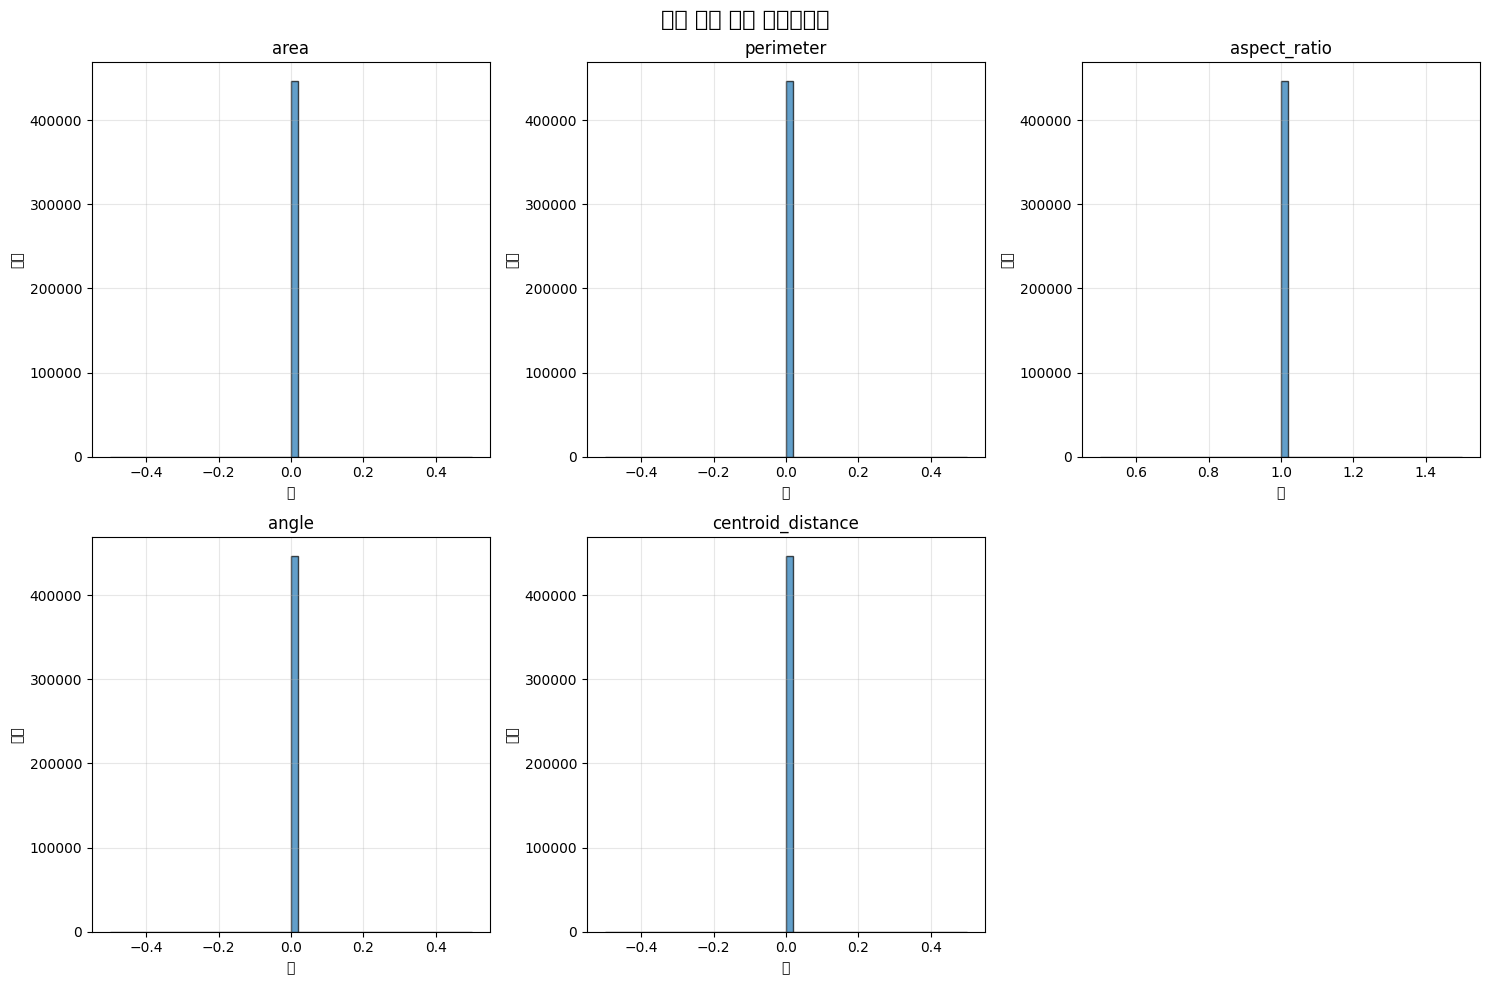

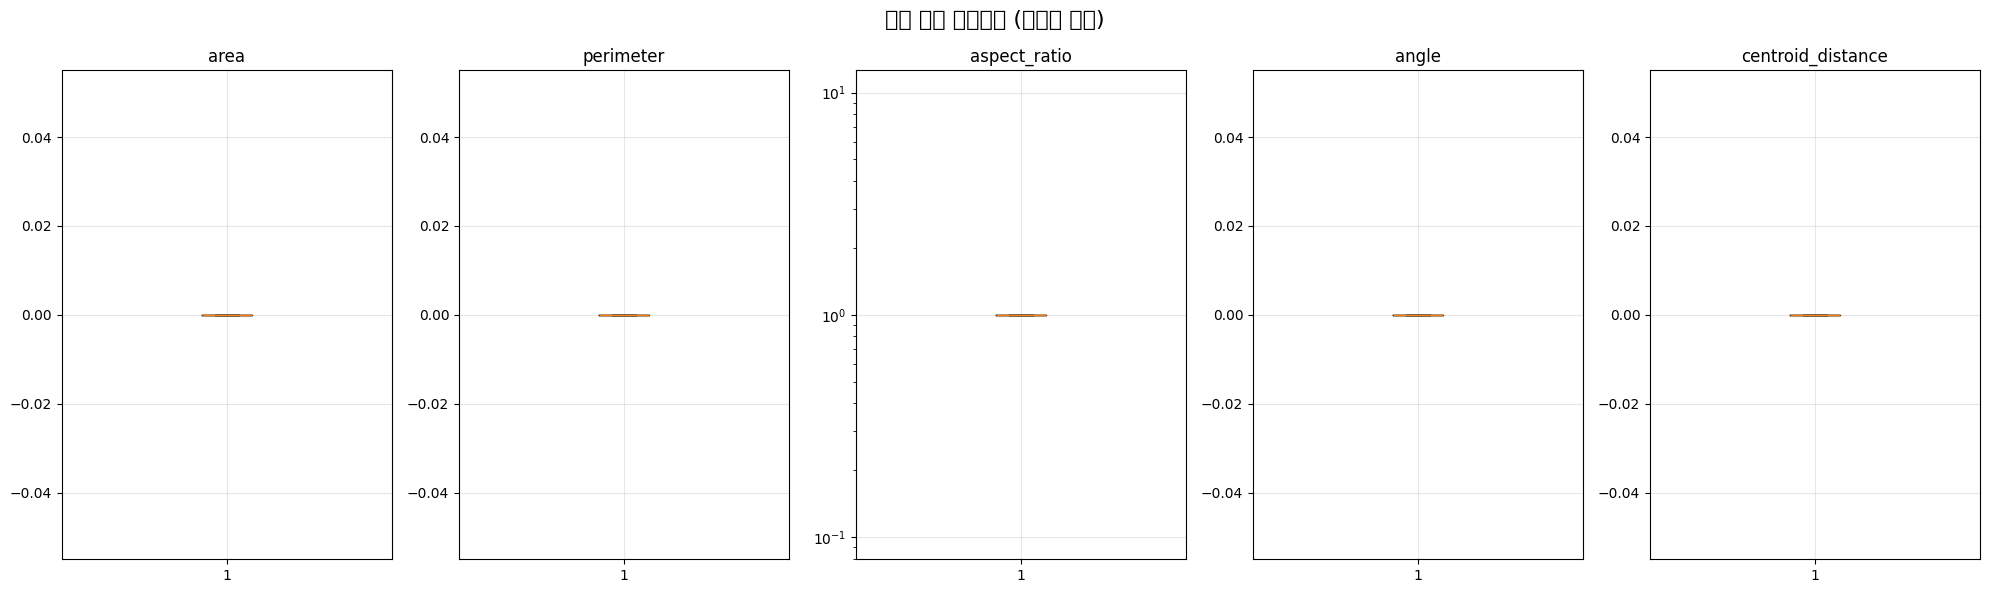

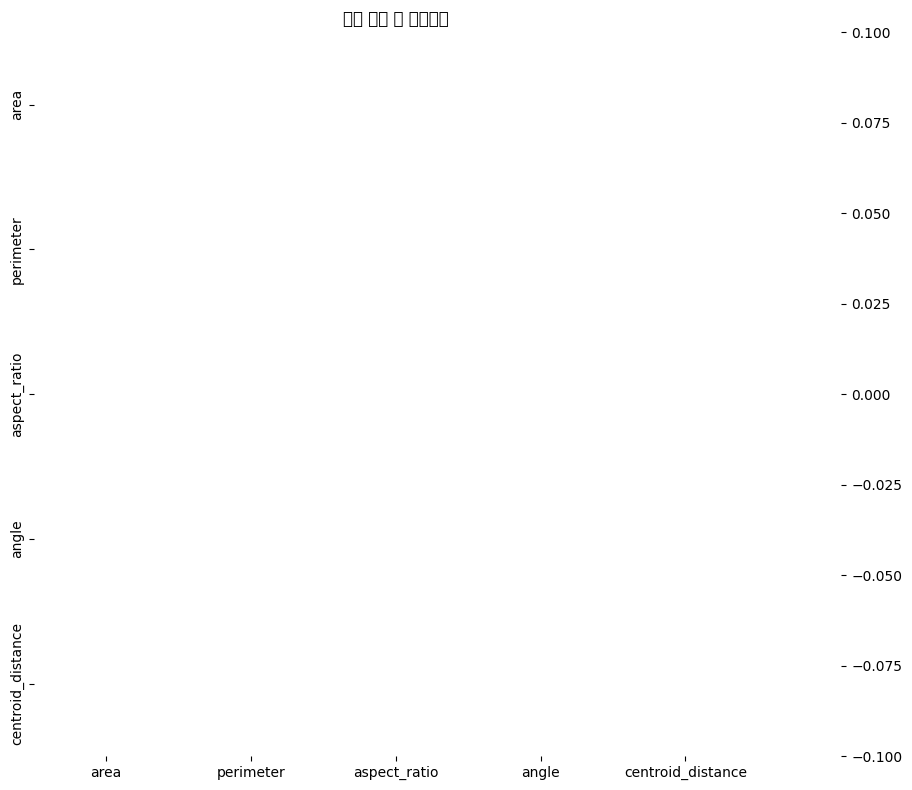

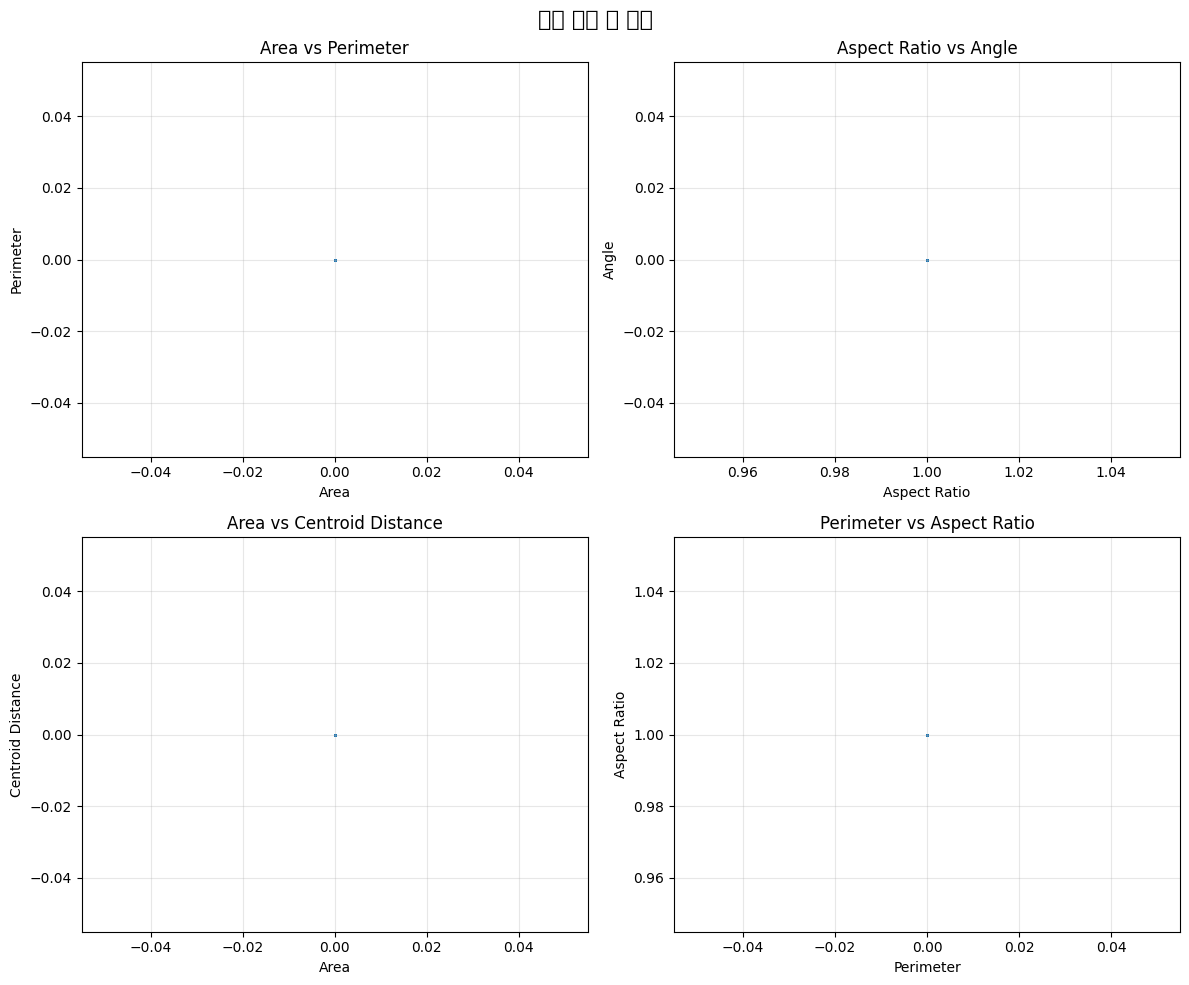

/nüîç Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Ï§ë...
area: 0Í∞úÏùò Ïù¥ÏÉÅÏπò (0.00%)
perimeter: 0Í∞úÏùò Ïù¥ÏÉÅÏπò (0.00%)
aspect_ratio: 0Í∞úÏùò Ïù¥ÏÉÅÏπò (0.00%)
angle: 0Í∞úÏùò Ïù¥ÏÉÅÏπò (0.00%)
centroid_distance: 0Í∞úÏùò Ïù¥ÏÉÅÏπò (0.00%)

‚ùó Ïù¥ÏÉÅÏπò ÏÉòÌîå Ïàò: 0Í∞ú
üìà ÌäπÏÑ± Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî Ï§ë...
/n=== Í∏∞Î≥∏ ÌÜµÍ≥Ñ Ï†ïÎ≥¥ ===
           area  perimeter  aspect_ratio     angle  centroid_distance
count  446464.0   446464.0      446464.0  446464.0           446464.0
mean        0.0        0.0           1.0       0.0                0.0
std         0.0        0.0           0.0       0.0                0.0
min         0.0        0.0           1.0       0.0                0.0
25%         0.0        0.0           1.0       0.0                0.0
50%         0.0        0.0           1.0       0.0                0.0
75%         0.0        0.0           1.0       0.0                0.0
max         0.0        0.0           1.0       0.0                0.0
/n=== Í≤∞Ï∏°Ïπò ÌôïÏù∏ ===
area                 0


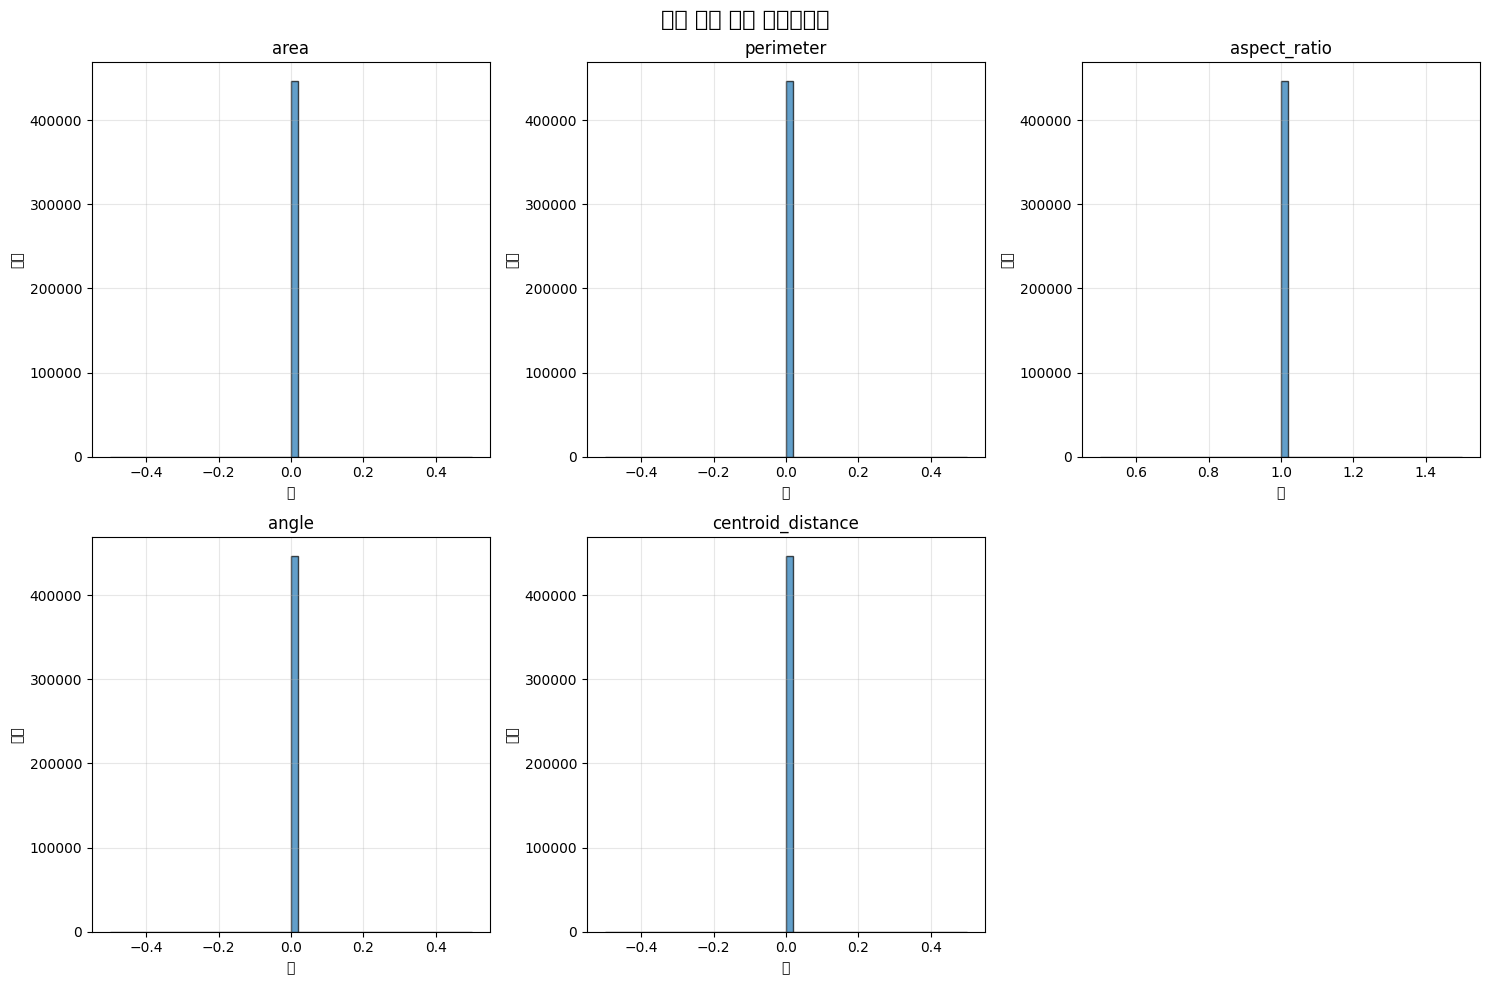

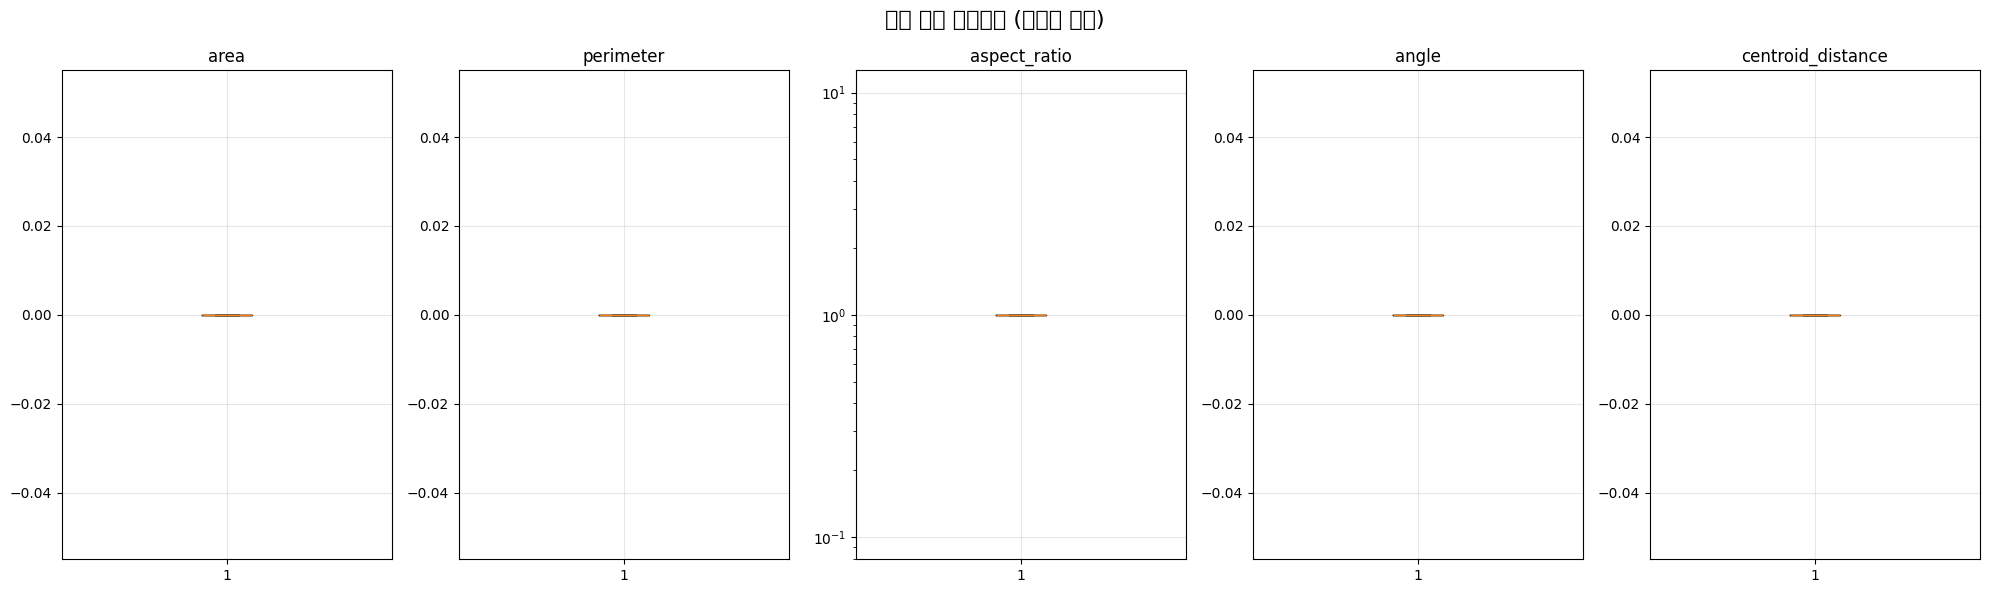

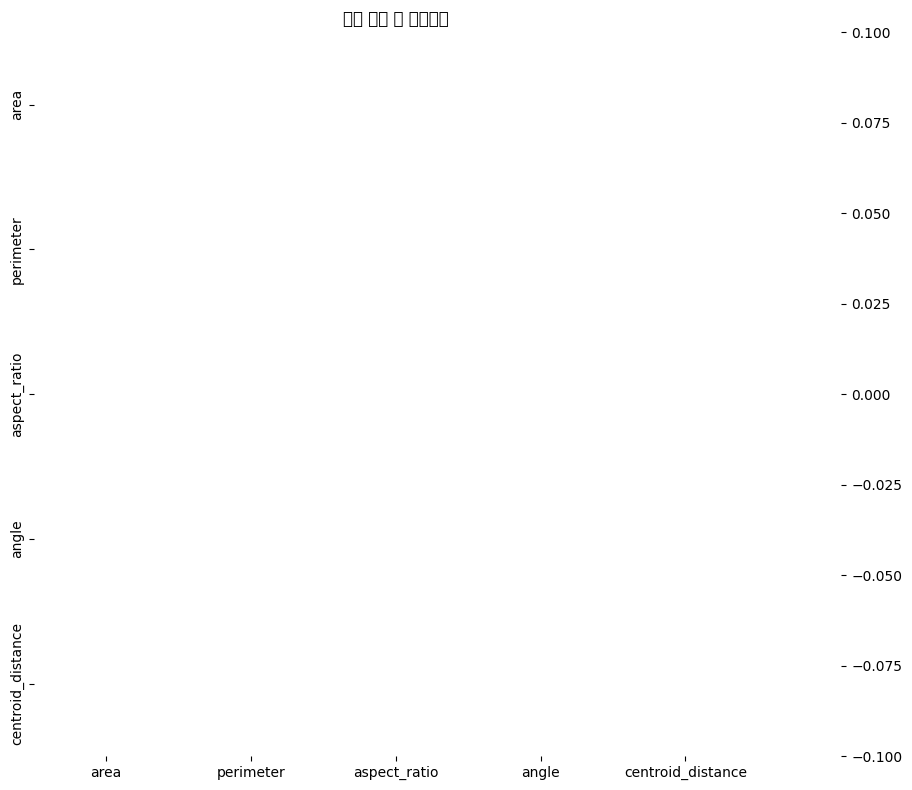

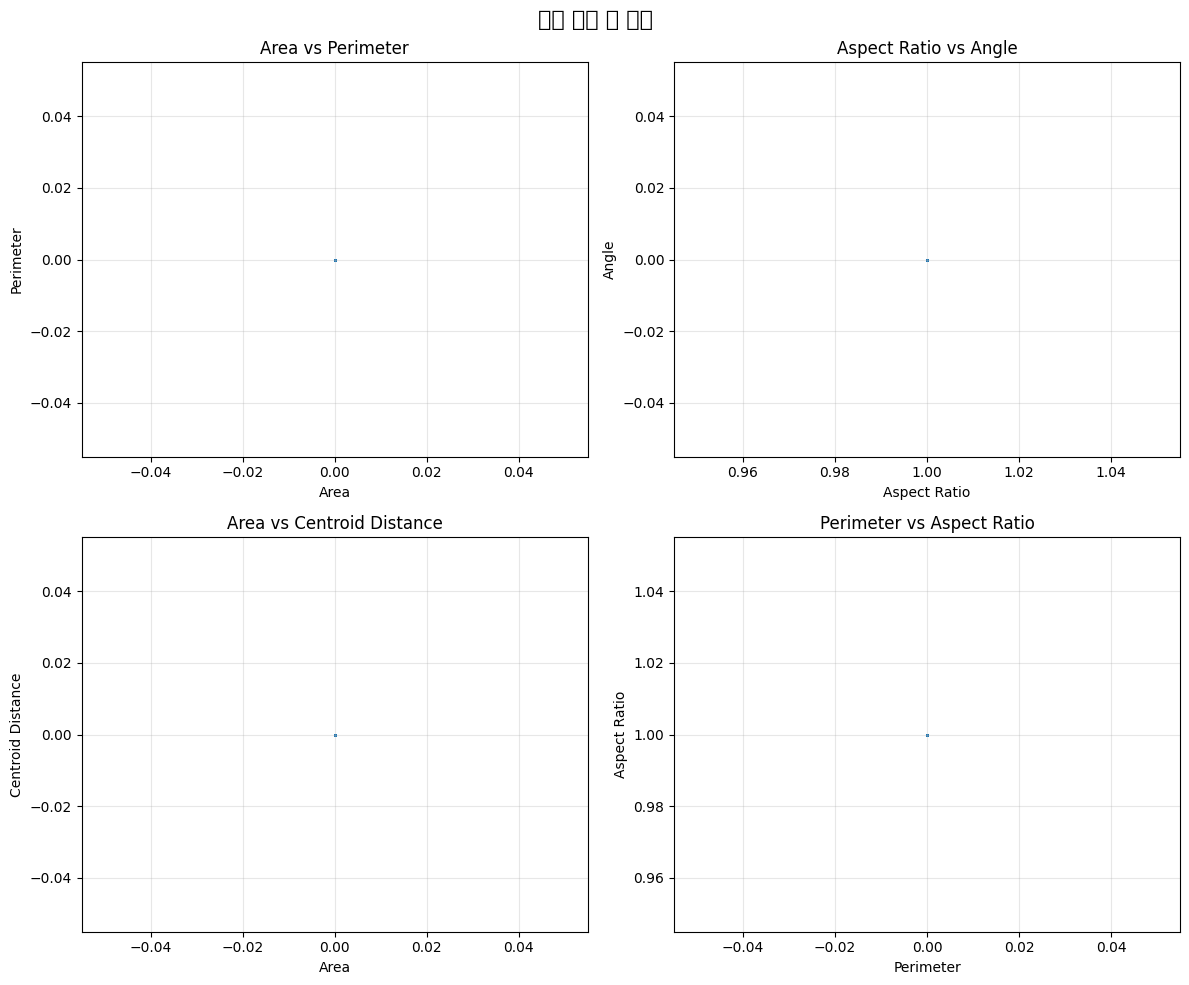

‚úÖ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï ÏôÑÎ£å!
üìÅ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨: C:/Users/konyang/Desktop/MeshCNN_TF/data
üìä Î∂ÑÏÑù Í≤∞Í≥º: C:\Users\konyang\Desktop\MeshCNN_TF\data\analysis
üîÑ TensorFlow Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Ï§ë...
‚úÖ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± ÏôÑÎ£å!
  - Î∞∞Ïπò ÌÅ¨Í∏∞: 8
  - ÏµúÎåÄ Ï†ïÏ†ê Ïàò: 2048
  - ÏµúÎåÄ Î©¥ Ïàò: 4096
/nüîç Îç∞Ïù¥ÌÑ∞ÏÖã ÌôïÏù∏:
ÏõêÎ≥∏ vertex ÏòàÏãú: [[-0.53860885 -0.25596175  0.7730666 ]
 [-0.533698   -0.25596175  0.76815575]
 [-0.533698   -0.2608726   0.7730666 ]]
normalize ÌõÑ: [[-0.53860885 -0.25596175  0.7730666 ]
 [-0.533698   -0.25596175  0.76815575]
 [-0.533698   -0.2608726   0.7730666 ]]
ÏÉòÌîå features:
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Î©¥ Í∞úÏàò: 4096
Ï†ïÏ†ê ÌèâÍ∑† Í±∞Î¶¨: 0.5711522
ÏõêÎ≥∏ vertex ÏòàÏãú: [[-0.5702083   0.07555358  0.80567425]
 [-0.56551105  0.07555358  0.800977  ]
 [-0.56551105  0.07085633  0.80567425]]
normalize ÌõÑ: [[-0.5702083   0.07555358  0.80567425]
 [-0.56551105  0.07

In [9]:
# =============================================================================
# Î©îÏù∏ Ïã§Ìñâ Î∂ÄÎ∂Ñ
# =============================================================================

if __name__ == "__main__":
    # ÏÑ§Ï†ï
    BASE_DIR = "C:/Users/konyang/Desktop/data(ÏßÑÏßúÏûÑ)/obj"
    SOURCE_DIR = BASE_DIR # ÏõêÎ≥∏ Î©îÏâ¨ ÌååÏùº ÎîîÎ†âÌÜ†Î¶¨
    TRAINING_DIR = "C:/Users/konyang/Desktop/MeshCNN_TF/data"      # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨
    
    # ÌïôÏäµ ÏÑ§Ï†ï - ÌôòÍ≤ΩÏóê ÎßûÍ≤å Ï°∞Ï†ïÌïòÏÑ∏Ïöî
    '''
    Í≥†ÏÑ±Îä• GPU (24GB+): MAX_VERTICES=5000, MAX_FACES=10000, BATCH_SIZE=32
    Ï§ëÍ∞Ñ GPU (8-16GB): MAX_VERTICES=3000, MAX_FACES=6000, BATCH_SIZE=16  
    Ï†ÄÏÇ¨Ïñë GPU (4-8GB): MAX_VERTICES=1500, MAX_FACES=3000, BATCH_SIZE=8
    '''
    MAX_VERTICES = 2048
    MAX_FACES = 4096
    BATCH_SIZE = 8
    
    print("=" * 60)
    print("Î©îÏâ¨ Îç∞Ïù¥ÌÑ∞ ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï")
    print("=" * 60)
    print(f"üîß ÌïòÎìúÏõ®Ïñ¥ ÏÑ§Ï†ï: Ï†ïÏ†ê={MAX_VERTICES}, Î©¥={MAX_FACES}, Î∞∞Ïπò={BATCH_SIZE}")
    
    # 1. ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï
    data_manager = setup_environment(
        source_dir=SOURCE_DIR,
        training_dir=TRAINING_DIR,
        max_vertices=MAX_VERTICES,
        max_faces=MAX_FACES
    )
    
    if data_manager is None:
        print("‚ùå ÌïôÏäµ ÌôòÍ≤Ω ÏÑ§Ï†ï Ïã§Ìå®")
        exit(1)
    
    # 2. ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_ds, val_ds, test_ds = create_datasets(
        training_dir=TRAINING_DIR,
        batch_size=BATCH_SIZE,
        max_vertices=MAX_VERTICES,
        max_faces=MAX_FACES
    )
    
    # 3. Îç∞Ïù¥ÌÑ∞ÏÖã ÌôïÏù∏
    print("/nüîç Îç∞Ïù¥ÌÑ∞ÏÖã ÌôïÏù∏:")
    for batch in train_ds.take(1):
        print(f"Batch shape:")
        for key, value in batch.items():
            print(f"  {key}: {value.shape}")
    
    print("/nüéâ Î™®Îì† Ï§ÄÎπÑ ÏôÑÎ£å! Ïù¥Ï†ú ÌïôÏäµÏùÑ ÏãúÏûëÌï† Ïàò ÏûàÏäµÎãàÎã§.")
    print(f"üìÇ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: {TRAINING_DIR}")
    print(f"üìä Î∂ÑÏÑù Í≤∞Í≥º: {TRAINING_DIR}/analysis/")
    print(f"üí° ÏÑ§Ï†ïÏùÑ Î≥ÄÍ≤ΩÌïòÎ†§Î©¥ ÏúÑÏùò MAX_VERTICES, MAX_FACES, BATCH_SIZE Í∞íÏùÑ Ï°∞Ï†ïÌïòÏÑ∏Ïöî.")